In [1]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [48]:
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
# import keyboard  # To handle 'q' key for exiting
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


In [4]:
# h0 = torch.zeros(hidden_layers, batch_size, hidden_dim).to(device)
# c0 = torch.zeros(hidden_layers, batch_size, hidden_dim).to(device)
# h = (h0, c0)
# inputs = sample_x

# model = LSTM_Model(input_size, hidden_layers, hidden_dim, output_size).to(device)
# outputs, hidden_outputs = model(inputs, h)

In [5]:
# Load pre-trained PCA, scaler, label encoder, and model
with open('pca2.pkl', 'rb') as f:
    pca = pickle.load(f)

with open('words_new_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('words_new_labelencoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# model = torch.load('lstm_model.pt')
# model.eval()


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
class LSTM_Model(nn.Module):
  def __init__(self, input_size, layers, hidden_dim, output_size):
    super(LSTM_Model, self).__init__()

    self.input_size = input_size
    self.layers = layers
    self.hidden_dim = hidden_dim
    self.output_size = output_size

    # lstm
    self.lstm = nn.LSTM(input_size = self.input_size,
                        hidden_size = self.hidden_dim,
                        num_layers = self.layers,
                        bias = True,
                        )

    # Fully connected layer | Output layer
    self.output_layer = nn.Linear(self.hidden_dim, self.output_size)

  def forward(self, inputs, hidden_inputs):

    # Ensure inputs and hidden states are of type float32
    inputs = torch.tensor(inputs, dtype=torch.float32)
    hidden_inputs = (
        torch.tensor(hidden_inputs[0], dtype=torch.float32),
        torch.tensor(hidden_inputs[1], dtype=torch.float32)
    )

    # LSTM expects input of shape (seq_length, batch_size, input_size)
    inputs = inputs.unsqueeze(0)  # Add sequence length dimension if needed

    # Pass through LSTM
    lstm_outputs, hidden_outputs = self.lstm(inputs, hidden_inputs)

    # Reshape LSTM outputs to (batch_size, hidden_dim)
    lstm_outputs = lstm_outputs.squeeze(0)  # Remove sequence length dimension

    # Pass through the fully connected layer
    outputs = self.output_layer(lstm_outputs)  # Shape: (batch_size, output_size)

    # outputs = F.softmax(outputs, dim=1)

    return outputs, hidden_outputs


In [7]:
input_size = 20    ## input features
hidden_layers = 5
hidden_dim = 1024
output_size = 124
seq_length = 75

In [8]:
model = LSTM_Model(input_size, hidden_layers, hidden_dim, output_size).to(device)

# Load the state dictionary into the model instance
state_dict = torch.load('lstm_new_model.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

C:\Users\hp\AppData\Local\Temp\ipykernel_12276\2406661032.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('lstm_new_model.pt', map_location=torch

<All keys matched successfully>

Starting webcam. Press 'q' to quit.
['TODAY']


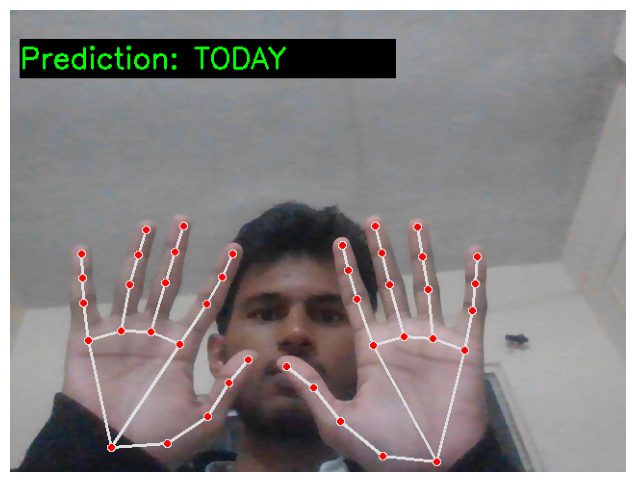

['TODAY']
['FREE']
['FREE']
['FREE']

Exiting...


In [49]:
# import keyboard  # To handle 'q' key for exiting

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

def extract_features(hand_landmarks):
    features = []
    for landmark in hand_landmarks.landmark:
        features.append(landmark.x)
        features.append(landmark.y)
        features.append(landmark.z)

    thumb_tip = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP]
    index_tip = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
    distance_thumb_index = np.sqrt(
        (thumb_tip.x - index_tip.x) ** 2 +
        (thumb_tip.y - index_tip.y) ** 2 +
        (thumb_tip.z - index_tip.z) ** 2
    )
    features.append(distance_thumb_index)

    return np.array(features)

# Open webcam
cap = cv2.VideoCapture(0)

print("Starting webcam. Press 'q' to quit.")

# Initialize h0 and c0
hidden_dim = model.hidden_dim
hidden_layers = 5
h0 = torch.zeros(hidden_layers, 1, hidden_dim).to(device)
c0 = torch.zeros(hidden_layers, 1, hidden_dim).to(device)

plt.ion()
fig, ax = plt.subplots(figsize=(8, 6))

try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image. Exiting...")
            break

        frame = cv2.flip(frame, 1)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        # If no hand landmarks are detected, display a "waiting" message
        if not results.multi_hand_landmarks:
            cv2.putText(frame, "Waiting for hand...", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        else:
            try:
                # Initialize features for two hands
                hand1_features = np.zeros(64)  # Default values if no landmarks detected
                hand2_features = np.zeros(64)

                # Extract features for the first detected hand
                if len(results.multi_hand_landmarks) >= 1:
                    hand1_features = extract_features(results.multi_hand_landmarks[0])

                # Extract features for the second detected hand if available
                if len(results.multi_hand_landmarks) > 1:
                    hand2_features = extract_features(results.multi_hand_landmarks[1])

                # Combine features for both hands (128 features total)
                combined_features = np.concatenate((hand1_features, hand2_features))

                # Transform and scale features
                features_pca = pca.transform([combined_features])
                features_scaled = scaler.transform(features_pca)

                # Convert to tensor and pass through the model
                features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
                with torch.no_grad():
                    outputs, (h0, c0) = model(features_tensor, (h0, c0))
                    predicted_label = label_encoder.inverse_transform([torch.argmax(outputs, axis=1).item()])
                    print(predicted_label)
                    if predicted_label in ["HAD", "THAT"]:
                        predicted_label = 5
                        
                # Draw landmarks and prediction
                for hand_landmarks in results.multi_hand_landmarks:
                    mp.solutions.drawing_utils.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                cv2.rectangle(frame, (10, 30), (400, 70), (0, 0, 0), -1)
                cv2.putText(frame, f"Prediction: {predicted_label[0]}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            except Exception as e:
                print(f"Error during prediction: {e}")
                continue

        # Display the frame using Matplotlib
        ax.clear()
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax.axis("off")
        plt.pause(0.1)  # Pause to update the frame at a reasonable speed

        # Exit on 'q' key using `keyboard`
        # if keyboard.is_pressed('q'):  # Check if 'q' is pressed
        #     print("Exiting...")
        #     break
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Waits for key press for 1ms
            print("Exiting...")
            break

except KeyboardInterrupt:
    print("\nExiting...")

finally:
    cap.release()
    hands.close()
    plt.close()


In [10]:
# !pip install keyboard

In [11]:
# !pip install opencv-python-headless